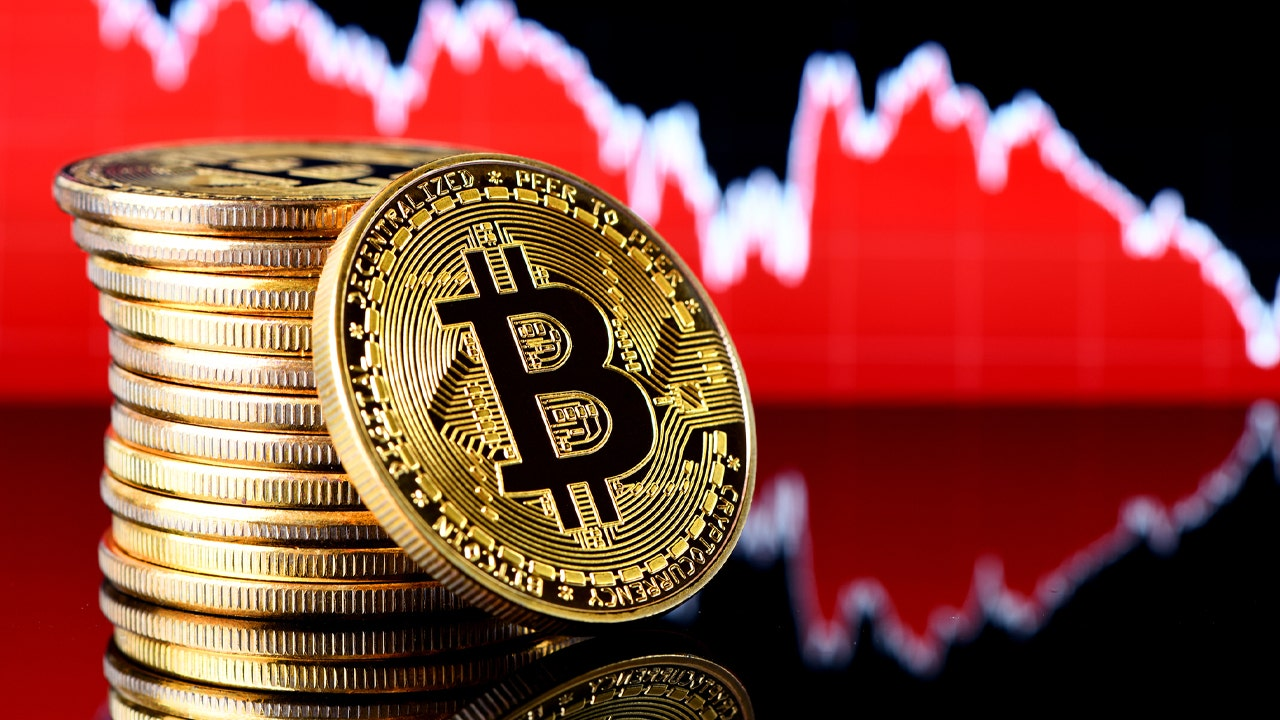

## sections
1. [ Introduction](#introduction)
2. [ Data_Quality_Assessment](#Data_Quality_Assessment)
3. [ EDA](#EDA)
4. [Preprocessing](#Preprocessing)
5.[Forecasting](#Forecasting)<br>

> ## Another Notebooks :[Crypo-LSTM-(2022 Actual Price :91%acc)](https://www.kaggle.com/yassershrief/crypo-lstm-2022-actual-price-91-acc/edit) ,<br>[LGBM Regressor Forecasting and Evaluation](https://www.kaggle.com/yassershrief/lgbm-regressor-forecasting-and-evaluation/edit)


<a id="1"></a> <br>
#  Introduction


## Forecasting returns

A fundamental task in financial modeling is predicting how prices will behave in the near future. Using the time-series of historical prices as training data, we want to predict if prices will go up or down, and by how much, namely the asset *returns*.

In this competition,the challenge is build machine learning models to predict the returns of `14 popular cryptocurrencies`, in the time scale of minutes to hours. You will have access to millions of rows of minute-by-minute cryptocurrency trading data, with which you'll design your forecasting models for all 14 assets simultaneously. Your predictions will be evaluated by how much they correlate with real market data collected during the three-month evaluation period after the competition has closed. 



# Dataset description

Now, let's dive into the data! We start by loading the competition's dataset and inspecting its basic properties. 

## Data features
We can see the different features included in the dataset. Specifically, the features included per asset are the following:
*   **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
*   **Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. `Asset_ID = 1` for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
*   **Count**: Total number of trades in the time interval (last minute).
*   **Open**:	Opening price of the time interval (in USD).
*   **High**:	Highest price reached during time interval (in USD).
*   **Low**: Lowest price reached during time interval (in USD).
*   **Close**:	Closing price of the time interval (in USD).
*   **Volume**:	Quantity of asset bought or sold, displayed in base currency USD.
*   **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
*   **Target**: Residual log-returns for the asset over a 15 minute horizon. 

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target, which we will get to later in more detail.

We also view the asset information, including the list of all assets, the `Asset_ID` to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

## Load the training set

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
from fbprophet.plot import plot_plotly, plot_components_plotly
from plotly.offline import iplot
import plotly.express as px
import time
import warnings
warnings.filterwarnings('ignore')

**Datatable** (heavily inspired by R's data.table) can read large datasets fairly quickly and is often faster than pandas. It is specifically meant for data processing of tabular datasets with emphasis on speed and support for large sized data. 👌

In [ ]:
import datatable as dt

In [ ]:
crypto_df = dt.fread('../input/g-research-crypto-forecasting/train.csv').to_pandas()
crypto_df.head(10)

**Our data is quite large...**

In [ ]:
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

#     return df

In [ ]:
crypto_df.info()

In [ ]:
# crypto_df = reduce_mem_usage(crypto_df)

We also view the asset information, including the list of all assets, the Asset_ID to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric

In [ ]:
asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
asset_details.sort_values("Weight", ascending=False)

# Data_Quality_Assessment

## Check Missing Values

In [ ]:
for n in range(14):
    print("Asset_ID =",n)
    crypto_n = crypto_df[crypto_df["Asset_ID"]==n]
    print(crypto_n.isna().sum())
    print('')

- The missing data in the Target column only
- Bitcoin has the least number of missing target values and Monero the most.


## Check Duplicated Values

In [ ]:
print(crypto_df.duplicated().sum())

There is no duplicated appointments record in this data set.

# EDA

I will do the following for faster and easier EDA, This will greatly help us reduce the time and memory used:
- Using the **merge()** function, for each of the rows in the `crypto_df` table, the corresponding coordinates are added from the `asset_details` table.
-  resample the minute Unix timestamps to daily timestamps. This reduces the amount of samples from 24,236,806 to 18102.<br>
  **Step1** create new time column with (mm.dd.yyyy) and (H:MM:SS) format using `pd.to_datetime`<br>
  **Step2** convert the previous column to column with (mm.dd.yyyy) format using `dt.strftime`<br>
  **Step3** because the different currencies are randomly located in our dataset then we use `groupby()` function to split the data into groups based on `Asset_Name`, `datetime_d`<br>
  **Step4** For a dataframe with a MultiIndex, `reset_index()` function is used to generate a new DataFrame with the index reset<br>
  **Step5** drop `timestamp` column<br>
  

In [ ]:
crypto_merge = pd.merge(crypto_df, asset_details, how="left", on="Asset_ID")
crypto_merge['datetime'] = pd.to_datetime(crypto_merge['timestamp'], unit='s') #Step1
crypto_merge['datetime_d'] = crypto_merge['datetime'].dt.strftime("%Y-%m-%d")  #Step2
df_g = crypto_merge.groupby(by = ["Asset_Name", 'datetime_d']).mean()          #Step3
crypto_mergee=df_g.reset_index()                                               #Step4
crypto_mergee.drop(['timestamp'],axis='columns', inplace=True)                 #Step5
crypto_mergee.head()

**We can create a function to plot data :** 

In [ ]:
def lineplot(df,varible):

    fig, ax = plt.subplots(figsize=(20,10))

    sns.lineplot(x='datetime_d', y=varible, hue='Asset_Name', 
                       data=df,legend='brief').set_title("Cryptocurrency "+ varible)
    plt.ylabel(varible+ ' Price')
    plt.xticks(rotation = 25)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend(title_fontsize='20')

**Question:** <span style="color:#FE1C0A;"> What is the different price scales between the different cryptocurrencies over time? </span><br>


In [ ]:
lineplot(crypto_mergee,'Open')

In [ ]:
lineplot(crypto_mergee,'Close')

#### Insights
- As we can see from open and close plots, nothing really happened before 2021 (Only Bitcoin had some transactions), 2021 was seemingly a breakthrough year for the cryptocurrency ecosystem.<br>
- As the price of BitCoin increased, the price of the other cryptocurrencies also increased.

**Question:** <span style="color:#FE1C0A;"> How far is the average price of Bitcoin from other cryptocurrencies, in descending order? </span><br>

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

crypto_mean=crypto_mergee[["Asset_Name","Close"]].groupby("Asset_Name")["Close"].agg(["mean"])
crypto_mean=crypto_mean.sort_values(by='mean',ascending=False)
my_cmap = plt.get_cmap("viridis")
crypto_mean.plot(kind="bar", ax=ax, color=my_cmap.colors, title="Mean Open Price")

**Question:** <span style="color:#FE1C0A;"> What is the correlation between other currencies apart from Bitcoin? </span><br>


In [ ]:
df_exclud=crypto_mergee[~crypto_mergee['Asset_Name'].isin(['Bitcoin'])]
lineplot(df_exclud,'Open')


**It seems that there is a strong correlation between the currencies each other**

**Question:** <span style="color:#FE1C0A;"> What is the quantity of assets bought or sold overtime? </span><br>


In [ ]:
lineplot(crypto_mergee,'Volume')

#### Insights
- nothing really happened before July 2020, 2021 was seemingly a popularity year for the **Dogecoin** .<br>


**Question:**  <span style="color:#FE1C0A;">What is the total Timestamps[entries] in this dataset for each asset? Are they equal? </span><br>

In [ ]:
labels= crypto_merge['Asset_Name'].value_counts().index

f, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='Asset_Name', data=crypto_merge,
              order = labels,
              palette="Set2"
           )
plt.xticks(rotation= 45,fontsize=12 )
ax.set_ylabel('Asset count', fontsize=15, color='r')
ax.set_xlabel('Asset', fontsize=14, color='r')

**Question:** 
<span style="color:#FE1C0A;">What's the percentage of weights given to each asset ?</span><br>
using **plotly library** with one single line

In [ ]:
labels = asset_details['Asset_Name']
values = asset_details['Weight']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial',title='Weights for each cryptocurrency'
                            )])
fig.show()

**Question:** 
<span style="color:#FE1C0A;">What are the changes in currency prices separately in different time periods (a month, 6 months or a year)</span><br>

 let’s do a quick visualization of our price column using the **plotly library**, which provides interactivity.

We see that from our plot there are two major spikes that might be influential on our model.<br>
We can also tell that the fluctuation in our price exaggerates as year increases.

In [ ]:
grouped = crypto_mergee.groupby('Asset_Name')
for name,group in grouped:

            
    # plot the open price
    
    x = group['datetime_d']
    y = group["Open"]
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=x, y=y))
    
    # Set title
    fig.update_layout(
        title_text="Time series plot of " +name+ " Open Price",
    )
    
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list(
                    [
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(step="all"),
                    ]
                )
            ),
            rangeslider=dict(visible=True),
            type="date",
        )
    )
    
    iplot(fig)
    

**Question:** 
<span style="color:#FE1C0A;">What is the difference between the highest and lowest trading price for a particular currency?</span><br>

## Candlestick charts

The trading data format is an aggregated form of market data including for`Open, High, Low and Close`. We can visualize this data through the commonly used candlestick bar chart, which allows traders to perform technical analysis on intraday values. The bar's body length represents the price range between the `open` and `close` of that day's trading. When the bar is **red**, it means the `close` was lower than the `open`, and **green** otherwise. These are also referred to as bullish and bearish candlesticks. The wicks above and below the bars show the `high` and `low` prices of that interval's trading.

We can visualize a slice of the Bitcoin prices using the `plotly` library. The bottom part of the plot shows a rangeslider, which you can use to zoom in the plot.

In [ ]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

# Preprocessing


## 1-Dealing with missing data

Notice that there are many gaps in the data. To work with most time series models, we should preprocess our data into a format without time gaps. To fill the gaps, we can use the `.reindex()` method for **forward filling**, filling gaps with the previous valid value.<br>

We know that the data is collected once every 60 seconds. If we have a gap of more than one minute between consecutive rows, then it indicates that the data is missing in between. Let us check that for each of the coins.
Thanks for [clarifying](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-crypto-forecasting).

In [ ]:
def check_gaps(df):
    gap_list = []
    for asset in df['Asset_Name'].unique():
        coin_df = df[df['Asset_Name']==asset].set_index('timestamp')
        df_asset = (coin_df.index[1:]-coin_df.index[:-1]).value_counts().reset_index()
        n_gaps = df_asset[df_asset["index"]!=60]["timestamp"].sum()
        max_gap = df_asset["index"].max()
        gap_list.append([asset, n_gaps, max_gap])
    gap_df = pd.DataFrame(gap_list)
    gap_df.columns = ["Asset_Name", "number_of_gaps", "max_gap_in_seconds"]
    return gap_df

In [ ]:
check_gaps(crypto_merge)

We simply cannot implement it on the dataframe because the currencies are randomly located.<br>
So we will fill in the missing data for each currency separately and then collect them again in one dataframe

In [ ]:
df_train = pd.DataFrame([])
for asset in crypto_merge['Asset_Name'].unique():
    df_asset = crypto_merge[crypto_merge['Asset_Name']==asset].set_index('timestamp')
    df_asset = df_asset.reindex(range(df_asset.index[0], df_asset.index[-1]+60, 60), method='ffill')
    df_train = pd.concat([df_train, df_asset])
df_train.reset_index(level=0, inplace=True)

In [ ]:
df_train.head()

#### Check... 

In [ ]:
check_gaps(df_train)

### 2-Feature Engineering 

#### A-Difference between opening and closing price & daily average price

In [ ]:
df_train['OC_diff']=df_train['Close']-df_train['Open']

In [ ]:
plt.figure(figsize=(15,8))
df_train1 = df_train.set_index('datetime')
Bitcoin = df_train1[df_train1["Asset_Name"]=='Bitcoin']
ethe = df_train1[df_train1["Asset_Name"]=='Ethereum']
btc_cash = df_train1[df_train1["Asset_Name"]=='Bitcoin Cash']
mone = df_train1[df_train1["Asset_Name"]=='Monero']

(Bitcoin['OC_diff']).plot(color='darkorange', label='Bitcoin')
(mone['OC_diff']).plot(color='yellow', label='Monero')
(ethe['OC_diff']).plot(color='cyan', label='Ethereum')
(btc_cash['OC_diff']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical difference between opening price and closing price of top 4 Crypto since 2018')
plt.legend()
plt.show()

By plotting the difference between daily opening and closing price, we found that:

- Daily opening price and closing price of BitCoin and BitCoin Cash varies the most, the differences can range from 1000 to more than 3000 dollars.
- The rest of the cryptocurrencies that we selected tends to be fairly stable

In [ ]:
# calculate daily average price
df_train['daily_avg'] = (df_train['Open'] + df_train['High'] + df_train['Low'] + df_train['Close']) / 4

#### B-Time Features

In [ ]:
# df_train['year'] = df_train.index.year
df_train['quarter'] = df_train.index.quarter
df_train['month'] = df_train.index.month
df_train['weekofyear'] = df_train.index.weekofyear
df_train['dayofyear'] = df_train.index.dayofyear
df_train['weekday'] = df_train.index.weekday

#### C-Lag Features

In [ ]:
# define function to compute log returns
def log_return(series, periods=1):
    # Copied from https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition
    return np.log(series).diff(periods=periods)


for i, asset_id in enumerate(asset_details.Asset_ID):
    df_train[('lret',  asset_id)] = log_return(df_train.Close)

#### D-Upper and lower shadow : From [competition tutorial](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

In [ ]:
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']


In [ ]:
# A utility function to build features from the original df
# It works for rows to, so we can reutilize it.

df_train['Upper_Shadow'] = upper_shadow(df_train)
df_train['Lower_Shadow'] = lower_shadow(df_train)

In [ ]:
df_train["high_div_low"] = df_train["High"] / df_train["Low"]
df_train["open_sub_close"] = df_train["Open"] - df_train["Close"]

#### E-Technical Indicators Features :
- It is a Technical Analysis library useful to do feature engineering from financial time series datasets (Open, Close, High, Low, Volume)
- **Ta** is very helpful library, but kernel doesn't support. You can learn more about the library [here](https://github.com/bukosabino/ta)
- There is more than 42 indicators i will try to implement it manually later

## Correlation between assets
Check Pearson correlation coefficient to prove if BitCoin price influences price of other cryptocurrencies

In [ ]:
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))   
assets_df = pd.DataFrame([])
for asset in crypto_merge['Asset_Name'].unique():
    df_asset = crypto_merge[crypto_merge['Asset_Name']==asset].set_index('timestamp')
    df_asset.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]# check corr last 3 months in dataset
    close_values = df_asset["Close"].fillna(0)
    close_values.name = asset
    assets_df = assets_df.join(close_values, how="outer")

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(assets_df.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Cryptos')
plt.show()

Based on the heatmap as well as some of the previous plots, we can say that Bitcoin and Ethereum prices does have strong impact to other cryptocurrencies.

- As the transaction volume of BitCoin and Ethereum increased, the volume of the other cryptocurrencies also increased.
- Prices of other cryptocurrency have strong positive correaltion with price of BitCoin

Finally i will drop the data after `2021-06-13` for traning processing... to understand why kindly refer to the [topic](https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285505)

In [ ]:
df_train = df_train[df_train.index < '2021-06-13 00:00:00']
#df_train.tail()

#### Save dataframe into jay file <br>
May I recommend the [notebook](https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets#Format:-jay) and this [topic](https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285291) to reading and saving large datasets

In [ ]:
!python3 -m pip install datatable --upgrade
import datatable as dt
dt.Frame(df_train).to_jay("df_train.jay")

# Forecasting
### Building the prediction model:

### To be Continue.....<br>
### [Machine Learning Models](https://www.kaggle.com/yassershrief/lgbm-regressor/edit)